In [48]:
import pandas as pd
from IPython.display import Image
import shutil
import os

from fastai.vision.all import *

import warnings
warnings.filterwarnings('ignore')

In [49]:
PATH_IMG_TRAIN = 'data/input/train_folder/'
DEFAULT_FIGSIZE = (7,6)

labels = {
    0: 'plantation',
    1: 'grassland',
    2: 'smallholder_agriculture',
}

In [50]:
df_test = pd.read_csv('data/input/raw/test.csv')
df_train = pd.read_csv('data/input/raw/train.csv')

df_test.example_path = df_test.example_path.str.replace('train_test_data','data/input/raw')
df_train.example_path = df_train.example_path.str.replace('train_test_data','data/input/raw')

df_train.head()

,label,latitude,longitude,year,example_path
0,0,-2.051853,111.826093,2001,data/input/raw/train/1297.png
1,2,-1.989349,105.309496,2013,data/input/raw/train/1199.png
2,0,1.223256,100.702217,2014,data/input/raw/train/1348.png
3,0,-2.342948,103.890226,2008,data/input/raw/train/2214.png
4,0,-0.126555,101.758175,2011,data/input/raw/train/2220.png


# Prepare data

In [52]:

for label in labels:
    os.makedirs(os.path.dirname(f'data/input/train_folder/{labels[label]}/'), exist_ok=True)

for example_path, label in zip(df_train.example_path, df_train.label):
    source_file = example_path
    filename = source_file.split('/')[-1]
    destination_file = f'data/input/train_folder/{labels[label]}/{labels[label]}-{filename}'
    shutil.copyfile(source_file, destination_file)

In [53]:
image_categories = os.listdir(PATH_IMG_TRAIN)
print(f"Categories: {image_categories}")

Categories: ['grassland', 'plantation', 'smallholder_agriculture']


In [54]:
def GetLabel(fileName):
    return fileName.split('-')[0]

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


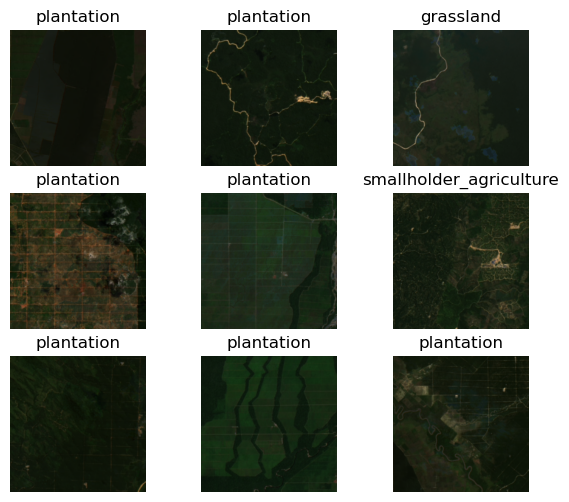

In [55]:
# Defining data loader
dls = ImageDataLoaders.from_name_func(
    PATH_IMG_TRAIN,
    get_image_files(PATH_IMG_TRAIN),
    valid_pct=0.2,
    seed=42,
    label_func=GetLabel,
    item_tfms=Resize(224),
    device=torch.device('cpu'),
    shuffle_train=True
    )

dls.train.show_batch(figsize=DEFAULT_FIGSIZE)

In [56]:
# Train model for 10 epochs
learn = vision_learner(
    dls,
    resnet34,
    metrics=accuracy,
    pretrained=True
    )
learn.dls.cpu()
learn.fine_tune(epochs=4)

epoch,train_loss,valid_loss,accuracy,time
0,1.463016,0.971261,0.678363,05:09


epoch,train_loss,valid_loss,accuracy,time
0,0.915878,0.934491,0.690058,07:23
1,0.626737,1.013666,0.736842,07:49
2,0.399230,0.982384,0.748538,07:06
3,0.267210,0.960117,0.754386,06:35


# Resultados Modelo

In [58]:
# Plot training metrics function
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

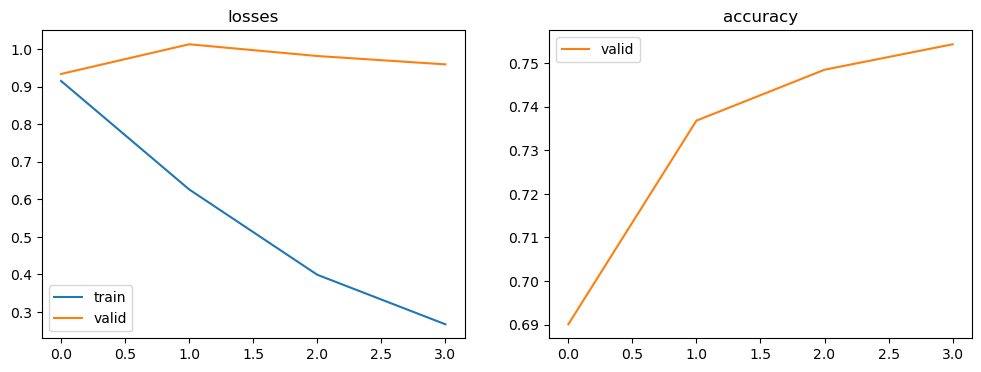

In [59]:
learn.recorder.plot_metrics()

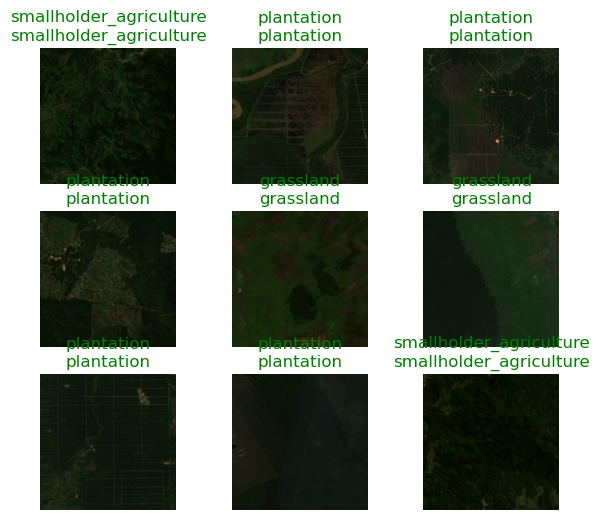

In [60]:
learn.show_results(figsize=DEFAULT_FIGSIZE)

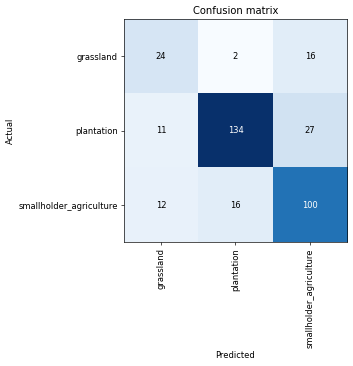

In [61]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=DEFAULT_FIGSIZE, dpi=60)

In [62]:
interp.print_classification_report()

                         precision    recall  f1-score   support

              grassland       0.51      0.57      0.54        42
             plantation       0.88      0.78      0.83       172
smallholder_agriculture       0.70      0.78      0.74       128

               accuracy                           0.75       342
              macro avg       0.70      0.71      0.70       342
           weighted avg       0.77      0.75      0.76       342



In [65]:
df_test.iloc[0].example_path

'data/input/raw/test/69.png'